# How to load your own data & Computing in different genome coordinates & Binding pattern of specific gene!
the rule is the same. You are just feeding the list of genes in that GO pathway into metadensity and compute them

In [1]:
# set up files associated with each genome coordinates
# you need to edit your own .ini files to point the gencode annotation files
import metadensity as md
md.settings.from_config_file('/home/hsher/Metadensity/config/hg19.ini')


# then import the modules
from metadensity.metadensity import *
from metadensity.plotd import *
import pandas as pd
import matplotlib.pyplot as plt


# I have a precompiles list of ENCODE datas as a csv that loads in this dataloader
import sys
sys.path.append('/home/hsher/Metadensity/scripts')
from dataloader import *
%matplotlib inline

plt.style.use('seaborn-white')

Using /projects/ps-yeolab3/bay001/annotations/hg19/hg19.fa
using /projects/ps-yeolab3/bay001/annotations/hg19/hg19.fa
Using:  /home/hsher/gencode_coords/gencode.v19.transcript.gff3


## Creating eCLIP object for your data

the eCLIP object needs a `pd.Series` that stores all the types of files

In [2]:
base_dir = '/home/hsher/jackie_ythdf2/'
from metadensity.readdensity import ReadDensity
def gather_data(cell_line):
    # store where all the files are
    data = pd.Series()
    
    # iterate over specific naming principle.
    for rep, rname in zip([1,2], ['R1', 'R2']):
        for seq in ['CLIP', 'INPUT']:
            # ===== BIGWIGS ======
            pos = '{}YTHDF2_trackhubs/hg19/YTHDF2.{}_{}_{}.umi.r1TrTr.sorted.STARUnmapped.out.sorted.STARAligned.outSo.rmDupSo.norm.{}.bw'.format(
            base_dir, seq, cell_line,rname, 'pos')
            neg = '{}YTHDF2_trackhubs/hg19/YTHDF2.{}_{}_{}.umi.r1TrTr.sorted.STARUnmapped.out.sorted.STARAligned.outSo.rmDupSo.norm.{}.bw'.format(
            base_dir, seq, cell_line,rname, 'neg')
            
            if seq == 'CLIP':
                data[f'minus_{rep-1}'] = neg
                data[f'plus_{rep-1}'] = pos
            if seq == 'INPUT':
                data[f'minus_control_{rep-1}'] = neg
                data[f'plus_control_{rep-1}'] = pos
            
            # ===== BAMS ======
            bam = '{}YTHDF2.{}_{}_{}.umi.r1TrTr.sorted.STARUnmapped.out.sorted.STARAligned.outSo.rmDupSo.bam'.format(
            base_dir, seq, cell_line, rname)
            
            if seq == 'CLIP':
                data[f'bam_{rep-1}'] = bam
                
            if seq == 'INPUT':
                data[f'bam_control_{rep-1}'] = bam
            
            # ===== INFORMATION =====
            
            # names
            data['uid']=cell_line # THIS THING NEEDS TO BE UNIQUE TO EACH ECLIP LIBRARY. it is called "Unique ID" (uid)
            # if uid is NOT UNIQUE it will RUIN EVERYTHING!
            data['RBP']=cell_line # name for display when plotting. You can write whatever there. won't interfere computation
            
            # ==== PEAKS ====
            if seq == 'CLIP':
                
                fname = '{}YTHDF2.{}_{}_{}.umi.r1TrTr.sorted.STARUnmapped.out.sorted.STARAligned.outSo.rmDupSo.peakClusters.normed.bed'.format(
                    base_dir, seq, cell_line, rname)
                
                data[f'bed_{rep-1}'] = fname
    # Intersect peaks
    
    fname = '{}idr_peaks/{}_1-{}_2.idr.final.bed'.format(base_dir, cell_line, cell_line)
    data['idr'] = fname
    
    
    
    return data

In [3]:
#For reference LM2 and MDA samples are MYC-dependent, MCF7 and SKBR3 are MYC independent
# these data are for YTHDF2 CLIP in different cell lines
lm2 = gather_data('LM2')
mda = gather_data('MDA')
mcf7 = gather_data('MCF7')
SKBR3 = gather_data('SKBR3')

/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


In [4]:
lm2 # how the Series should look like

minus_0            /home/hsher/jackie_ythdf2/YTHDF2_trackhubs/hg1...
plus_0             /home/hsher/jackie_ythdf2/YTHDF2_trackhubs/hg1...
bam_0              /home/hsher/jackie_ythdf2/YTHDF2.CLIP_LM2_R1.u...
uid                                                              LM2
RBP                                                              LM2
bed_0              /home/hsher/jackie_ythdf2/YTHDF2.CLIP_LM2_R1.u...
minus_control_0    /home/hsher/jackie_ythdf2/YTHDF2_trackhubs/hg1...
plus_control_0     /home/hsher/jackie_ythdf2/YTHDF2_trackhubs/hg1...
bam_control_0      /home/hsher/jackie_ythdf2/YTHDF2.INPUT_LM2_R1....
minus_1            /home/hsher/jackie_ythdf2/YTHDF2_trackhubs/hg1...
plus_1             /home/hsher/jackie_ythdf2/YTHDF2_trackhubs/hg1...
bam_1              /home/hsher/jackie_ythdf2/YTHDF2.CLIP_LM2_R2.u...
bed_1              /home/hsher/jackie_ythdf2/YTHDF2.CLIP_LM2_R2.u...
minus_control_1    /home/hsher/jackie_ythdf2/YTHDF2_trackhubs/hg1...
plus_control_1     /home/hsher/jac

In [5]:
# it's worthwhile to see if the data path is correct
import os
lm2.apply(os.path.isfile) # ok it's good to learn every path exists! yeee ha

minus_0             True
plus_0              True
bam_0               True
uid                False
RBP                False
bed_0               True
minus_control_0     True
plus_control_0      True
bam_control_0       True
minus_1             True
plus_1              True
bam_1               True
bed_1               True
minus_control_1     True
plus_control_1      True
bam_control_1       True
idr                 True
dtype: bool

In [6]:
clips = []

# then you build eCLIP from each pd.Series!
for data in [lm2, mda, mcf7, SKBR3]:

    clips.append(eCLIP.from_series(data, single_end = True))

## Build Metagene for MYC only

In [7]:
myc = transcript.filter(lambda x: x.attrs['gene_name']=='MYC').saveas()
print(myc)

chr8	HAVANA	transcript	128748330	128753674	.	+	.	ID=ENST00000377970.2;Parent=ENSG00000136997.10;gene_id=ENSG00000136997.10;transcript_id=ENST00000377970.2;gene_type=protein_coding;gene_status=KNOWN;gene_name=MYC;transcript_type=protein_coding;transcript_status=KNOWN;transcript_name=MYC-001;level=2;protein_id=ENSP00000367207.2;tag=basic,CCDS;ccdsid=CCDS6359.2;havana_gene=OTTHUMG00000128475.3;havana_transcript=OTTHUMT00000250277.3;



In [8]:
all_meta_raw = []
for e in clips:
    m = Metadensity(e, name = e.name, transcripts = myc, 
                    background_method = None, 
                    normalize = None) # raw read coverage in RPM
    m.get_density_array()
    all_meta_raw.append(m)

Using: /home/hsher/Metadensity/metadensity/data/hg19/gencode
Done building metagene
Using: /home/hsher/Metadensity/metadensity/data/hg19/gencode
Done building metagene
Using: /home/hsher/Metadensity/metadensity/data/hg19/gencode
Done building metagene
Using: /home/hsher/Metadensity/metadensity/data/hg19/gencode
Done building metagene


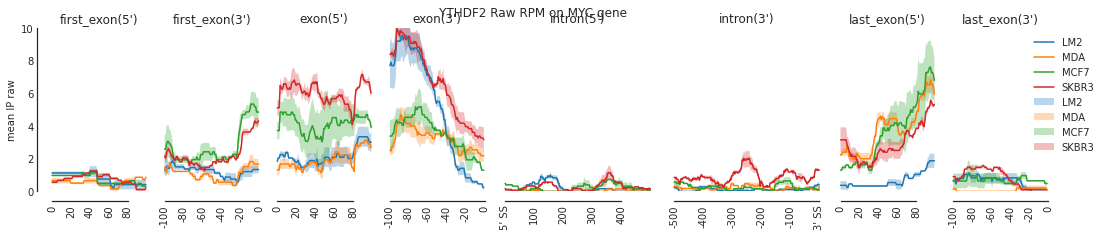

In [9]:

f = plot_mean_density(all_meta_raw, features_to_show = generic_rna, ymax = 10)
plt.suptitle('YTHDF2 Raw RPM on MYC gene')
f=beautify(f)